In [12]:
import tensorflow as tf
import matplotlib.pyplot as plt

from tablenet import TableNet

In [13]:
list_ds = tf.data.Dataset.list_files('/Users/sky/Projects/tablenet/dataset/Marmot_data/*.xml')

In [14]:
img_height, img_width = 256, 256

def normalize(input_image):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  return input_image

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

def decode_mask_img(img):
  # convert the compressed string to a 2D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=1)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
  file_path = tf.strings.regex_replace(file_path, '.xml', '.jpg')

  mask_file_path = tf.strings.regex_replace(file_path, '.jpg', '.jpeg')

  table_mask_file_path = tf.strings.regex_replace(mask_file_path, 'Marmot_data', 'table_mask')
  column_mask_file_path = tf.strings.regex_replace(mask_file_path, 'Marmot_data', 'column_mask')

  img = normalize(decode_img(tf.io.read_file(file_path)))
  table_mask = normalize(decode_mask_img(tf.io.read_file(table_mask_file_path)))
  column_mask = normalize(decode_mask_img(tf.io.read_file(column_mask_file_path)))

  return img, {"table_output" : table_mask, "column_output" : column_mask }

In [15]:
# dataset = list_ds.map(process_path)

DATASET_SIZE = len(list(list_ds))
train_size = int(0.9 * DATASET_SIZE)
test_size = int(0.1 * DATASET_SIZE)

train = list_ds.take(train_size)
test = list_ds.skip(train_size)

TRAIN_LENGTH = len(list(train))
BATCH_SIZE = 2
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train = train.shuffle(BUFFER_SIZE)

train = train.map(process_path,
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)

test = test.map(process_path)

train_dataset = train.batch(BATCH_SIZE).repeat().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [16]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'Table Mask', 'Column Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

(256, 256, 3)


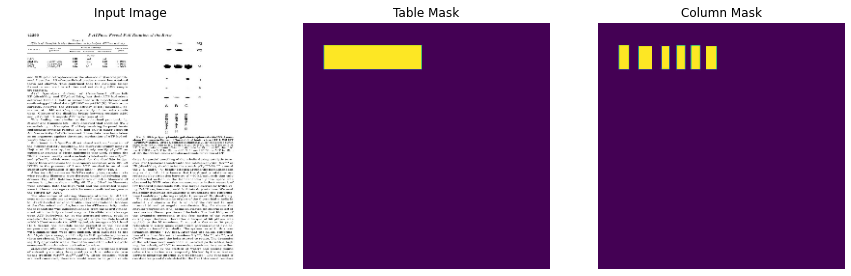

(256, 256, 3)


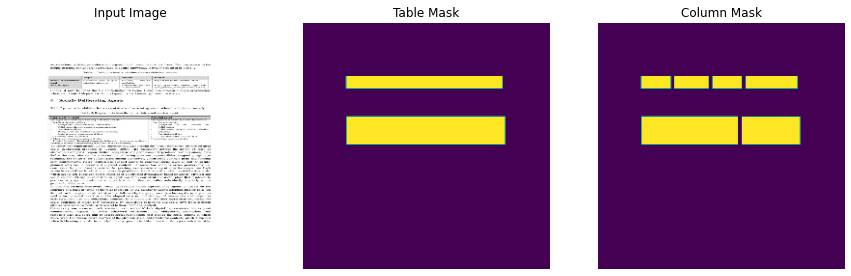

In [17]:
for image, mask  in train.take(2):
  print(image.shape)
  # print(mask.shape)
  display([image, mask['table_output'], mask['column_output']])

In [18]:
import inspect
# print(inspect.getsource(TableNet))

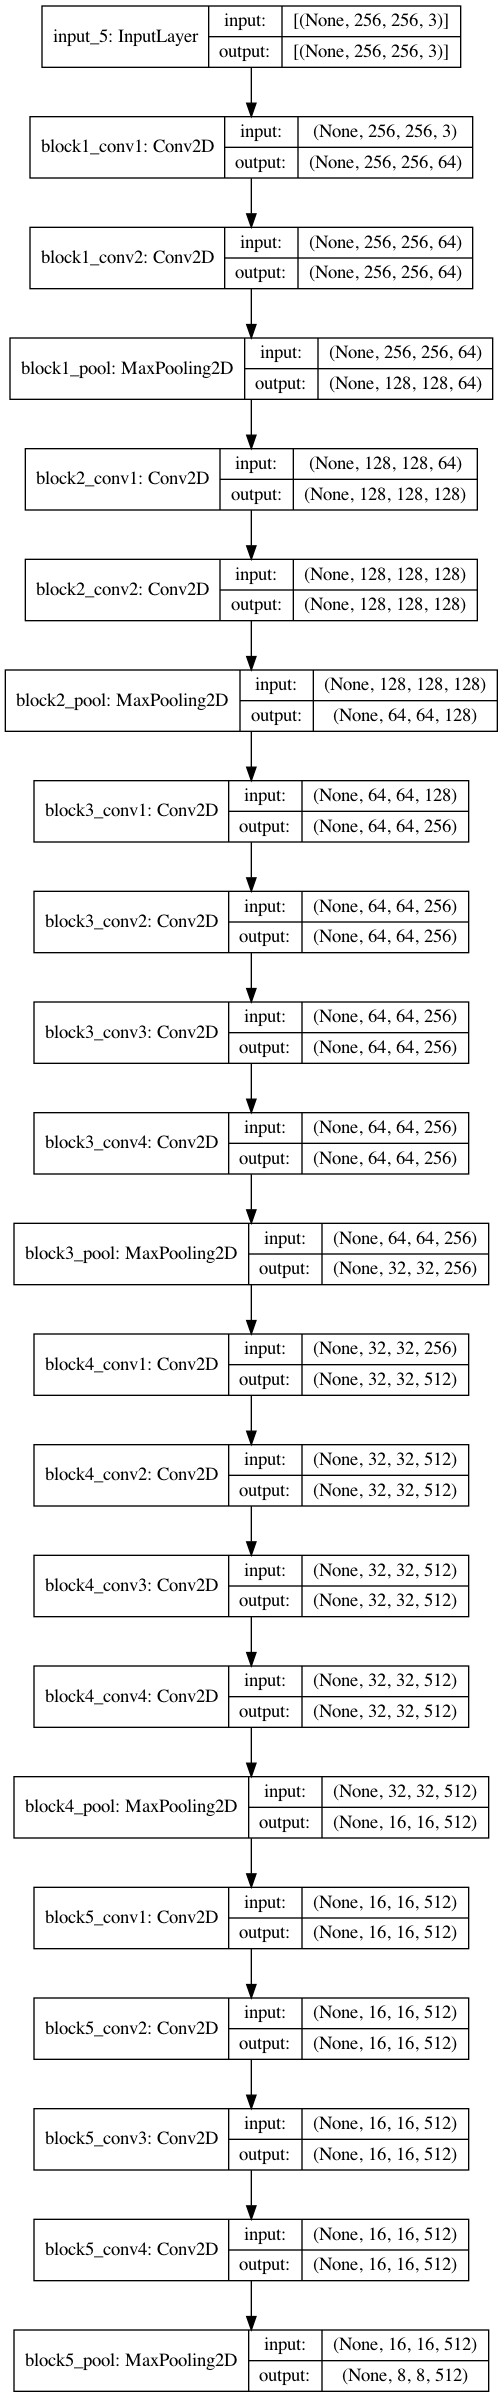

In [19]:
vgg19_model = tf.keras.applications.vgg19.VGG19(
    input_shape=(256, 256, 3), include_top=False, weights='imagenet')
tf.keras.utils.plot_model(vgg19_model, show_shapes=True)

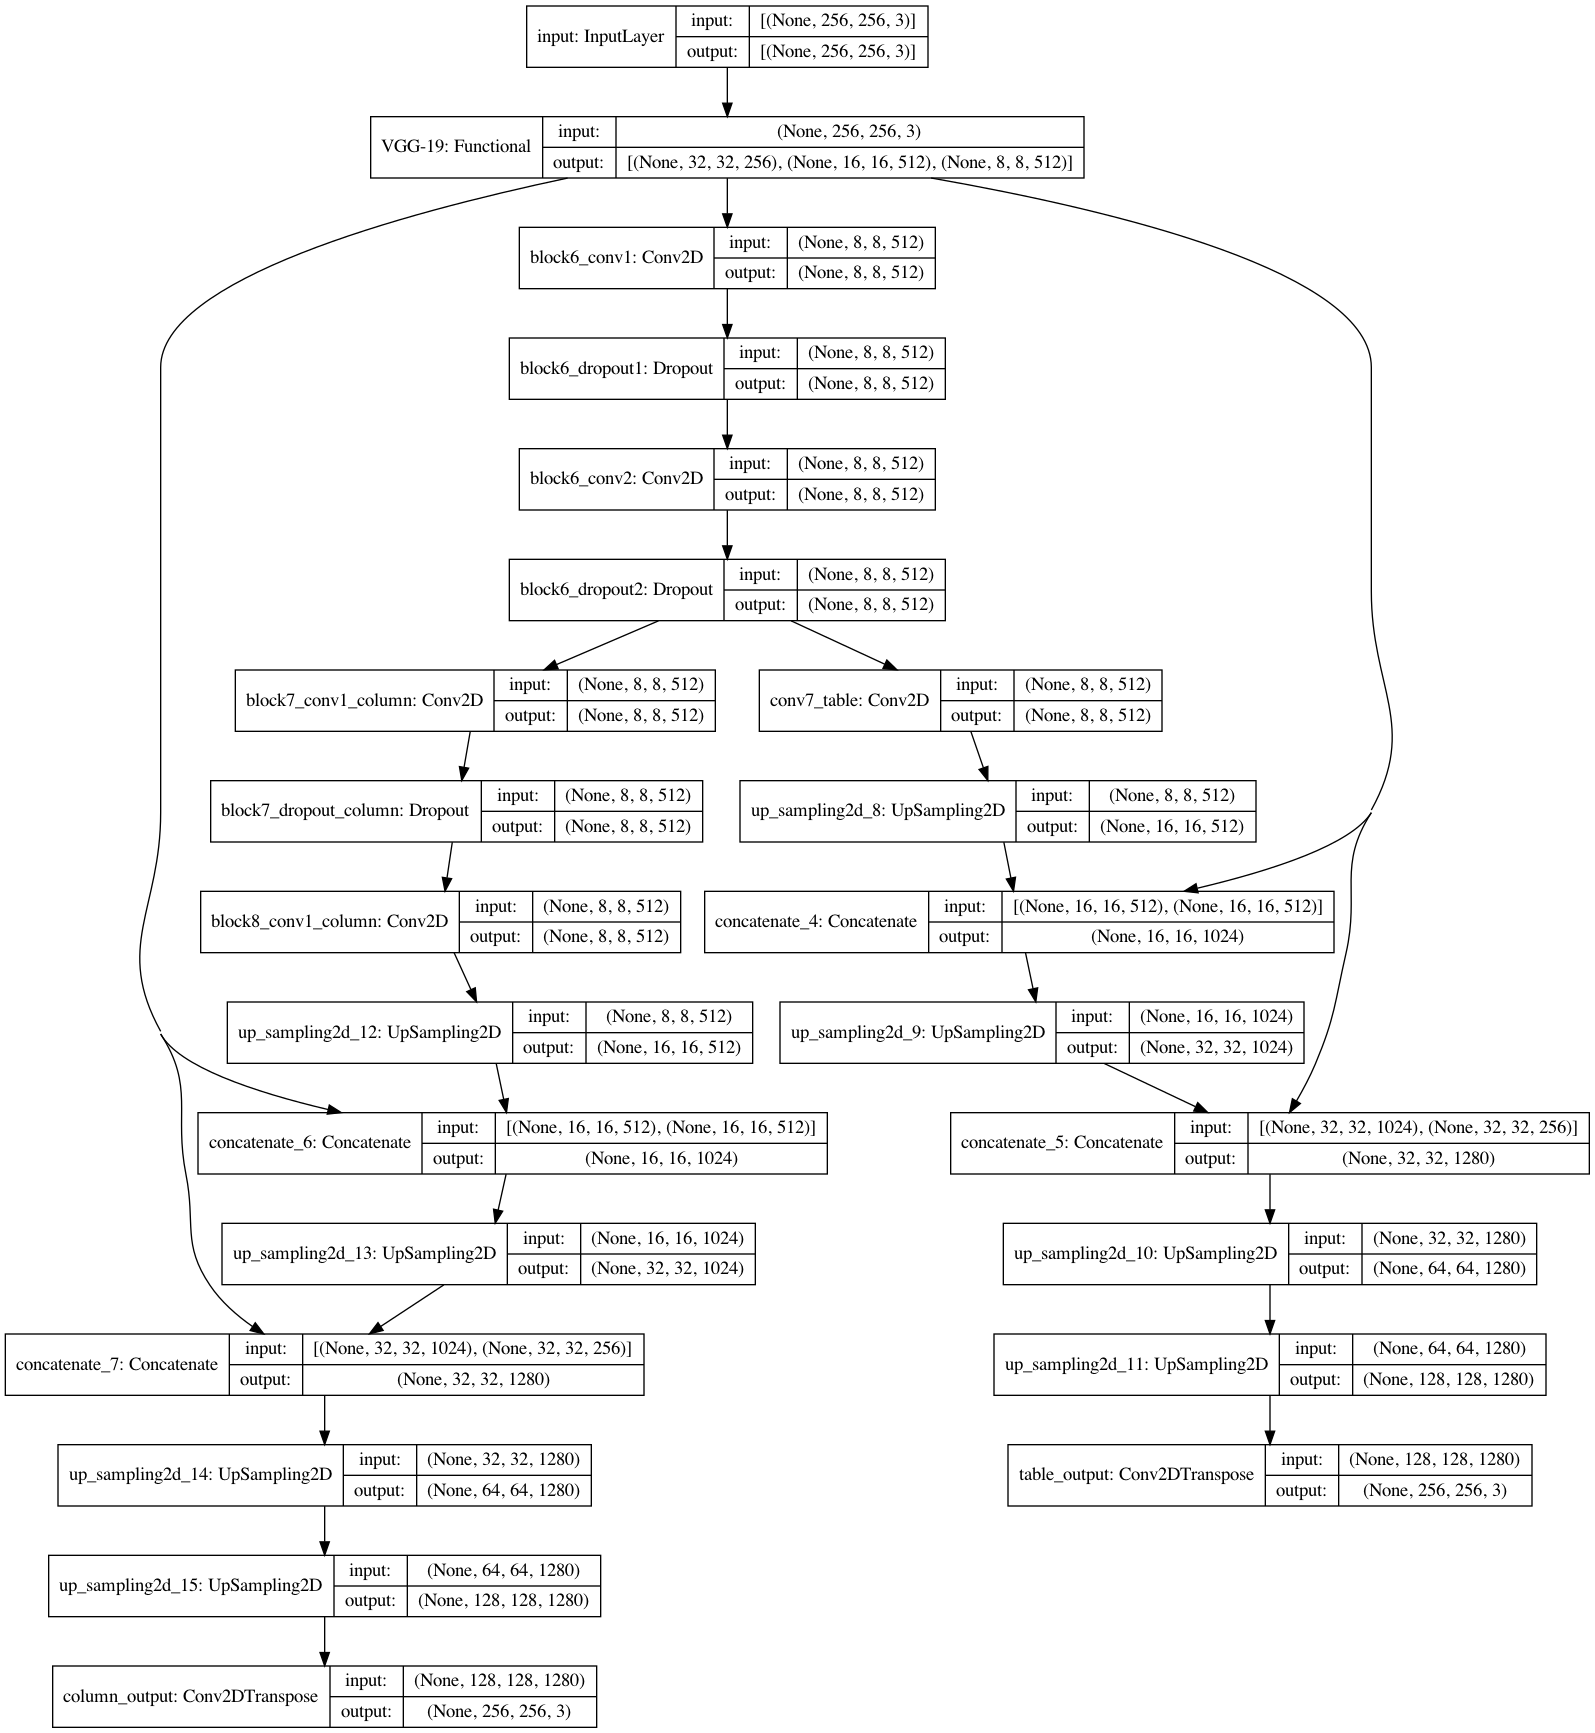

In [20]:
model = TableNet.build()
tf.keras.utils.plot_model(model, show_shapes=True)

In [21]:
losses = {
	"table_output": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
	"column_output": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
}

lossWeights = {"table_output": 1.0, "column_output": 1.0}

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, epsilon=1e-08),
              loss=losses,
              metrics=['accuracy'],
              loss_weights=lossWeights)

# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

In [22]:
def create_mask(pred_mask1, pred_mask2):
  pred_mask1 = tf.argmax(pred_mask1, axis=-1)
  pred_mask1 = pred_mask1[..., tf.newaxis]


  pred_mask2 = tf.argmax(pred_mask2, axis=-1)
  pred_mask2 = pred_mask2[..., tf.newaxis]
  return pred_mask1[0], pred_mask2[0]


In [23]:
for image, mask in train_dataset.take(1):
  sample_image, sample_mask1, sample_mask2 = image, mask['table_output'], mask['column_output']

print(sample_image.shape)

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, (mask1, mask2) in dataset.take(num):
      pred_mask1, pred_mask2 = model.predict(image, verbose=1)
      table_mask, column_mask = create_mask(pred_mask1, pred_mask2)
      
      display([image[0], table_mask, column_mask])
  else:
    pred_mask1, pred_mask2 = model.predict(sample_image, verbose=1)
    table_mask, column_mask = create_mask(pred_mask1, pred_mask2)

    display([sample_image[0], table_mask, column_mask])

(2, 256, 256, 3)


In [ ]:
show_predictions()

In [ ]:
from IPython.display import clear_output

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath="mymodel_{epoch}",
        save_best_only=True,
        monitor="val_loss",
        verbose=1,
    )

early_stoping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        verbose=1,
    )



In [ ]:
EPOCHS = 5000
VAL_SUBSPLITS = 5
VALIDATION_STEPS = test_size//BATCH_SIZE//VAL_SUBSPLITS


model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback(), model_checkpoint])

In [ ]:
show_predictions(train_dataset, 5)

In [ ]:
model.save('model_66')

In [ ]:
!zip -r model66.zip model_66/

In [ ]:
!cp model66.zip '/content/drive/My Drive/Marmot/'